## Fisher–KPP inverse problem



#### Install Libraries

In [68]:
!pip install pinnstorch
!pip install lightning

#### Import Libraries

In [69]:
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import lightning.pytorch as pl
import pinnstorch




In [70]:
class KPPDataset(Dataset):
    """
    Dataset of scattered observations (t, x) -> u.

    CSV is assumed to have columns:
        't', 'x', 'u_exact', 'u_noisy'
    We will use 'u_noisy' for the inverse problem.
    """

    def __init__(self, csv_path: str):
        super().__init__()

        # Read data from CSV
        df = pd.read_csv(csv_path)

        # N x 1 arrays
        t = df["t"].values.astype(np.float32).reshape(-1, 1)
        x = df["x"].values.astype(np.float32).reshape(-1, 1)
        u = df["u_noisy"].values.astype(np.float32).reshape(-1, 1)

        # Stack as [x, t] so that:
        #   X[:, 0] = x,  X[:, 1] = t
        # This matches the logic in training_step:
        #   x_data = X_data[:, 0:1]
        #   t_data = X_data[:, 1:2]
        self.X = torch.from_numpy(np.concatenate([x, t], axis=1))  # (N, 2)
        self.u = torch.from_numpy(u)                               # (N, 1)

        # Store bounds (kept, but we will NOT rely on them for BC/IC/PDE sampling)
        self.t_min = float(t.min())
        self.t_max = float(t.max())
        self.x_min = float(x.min())
        self.x_max = float(x.max())

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.u[idx]


In [71]:
def sample_collocation_points(
    N_f: int,
    x_min: float,
    x_max: float,
    t_min: float,
    t_max: float,
    device: torch.device,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Sample collocation points (x_f, t_f) uniformly in the domain.
    These points are used only to enforce the PDE (physics loss).
    """
    x_f = (x_max - x_min) * torch.rand(N_f, 1, device=device) + x_min
    t_f = (t_max - t_min) * torch.rand(N_f, 1, device=device) + t_min

    x_f.requires_grad_(True)
    t_f.requires_grad_(True)

    return x_f, t_f


def sample_boundary_points(
    N_b: int,
    t_min: float,
    t_max: float,
    device: torch.device,
):
    """
    Dirichlet BCs matching the forward solver:
        u(0, t) = 0,  u(L, t) = 0,  for t in [0, T].
    Here we hard-code L=10, T=5 by passing x=0 and x=10.
    """
    t_b = (t_max - t_min) * torch.rand(N_b, 1, device=device) + t_min
    x_b0 = torch.zeros((N_b, 1), device=device)          # x = 0
    x_b1 = torch.full((N_b, 1), 10.0, device=device)     # x = 10
    return x_b0, t_b, x_b1, t_b


def sample_initial_points(
    N_0: int,
    device: torch.device,
):
    """
    Initial condition matching the forward solver:
        u(x, 0) = exp(-(x - 5)^2),  for x in [0, 10].
    """
    x_0 = 10.0 * torch.rand(N_0, 1, device=device)       # x in [0,10]
    t_0 = torch.zeros((N_0, 1), device=device)           # t = 0
    u_0 = torch.exp(-(x_0 - 5.0) ** 2)                   # center at 5
    return x_0, t_0, u_0



In [72]:
class FisherKPPNet(nn.Module):
    """
    Neural network u(x,t) + learnable PDE parameters D and r.
    Receives lb, ub as 2D tensors: [x_min, t_min], [x_max, t_max].
    """

    def __init__(self, lb, ub):
        super().__init__()

        self.lb = lb
        self.ub = ub

        # FCN from pinnstorch
        self.net = pinnstorch.models.FCN(
            layers=[2, 100, 100, 100, 100, 1],
            output_names=["u"],
            lb=lb,
            ub=ub,
        )

        # Trainable PDE parameters
        self.D = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))
        self.r = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))

    def forward(self, x, t):
        """
        pinnstorch FCN expects `spatial` to be a tuple.
        For 1D x, wrap it as (x,).
        """
        outputs = self.net((x,), t)
        outputs["D"] = self.D
        outputs["r"] = self.r
        return outputs


In [73]:
def fisher_kpp_pde(outputs, x, t):
    """
    Fisher–KPP PDE:
        u_t = D u_xx + r u (1 - u)
    """
    u = outputs["u"]

    # First-order derivatives
    u_x, u_t = pinnstorch.utils.gradient(u, [x, t])

    # Second derivative in x
    u_xx = pinnstorch.utils.gradient(u_x, x)[0]

    D = outputs["D"]
    r = outputs["r"]

    # Physics residual
    f = u_t - D * u_xx - r * u * (1 - u)
    return f


In [74]:
class FisherKPP_PINN(pl.LightningModule):
    """
    Physics-Informed Neural Network for the Fisher–KPP inverse problem.

    Loss = data_loss + lambda_pde * pde_loss + lambda_bc * bc_loss + lambda_ic * ic_loss

    - data_loss: match u(x,t) to noisy observations
    - pde_loss : enforce Fisher–KPP PDE at collocation points
    - bc_loss  : enforce Dirichlet BCs u(0,t)=0 and u(10,t)=0
    - ic_loss  : enforce IC u(x,0)=exp(-(x-5)^2)
    """

    def __init__(
        self,
        dataset: KPPDataset,
        n_f: int = 10000,
        n_b: int = 2000,
        n_0: int = 2000,
        lambda_pde: float = 1.0,
        lambda_bc: float = 50.0,
        lambda_ic: float = 50.0,
        lr: float = 1e-3,
    ):
        super().__init__()

        self.save_hyperparameters(ignore=["dataset"])

        # Keep your original lb/ub logic (for normalization in FCN)
        lb = torch.tensor([dataset.x_min, dataset.t_min], dtype=torch.float32)
        ub = torch.tensor([dataset.x_max, dataset.t_max], dtype=torch.float32)
        self.net = FisherKPPNet(lb=lb, ub=ub)

        self.dataset = dataset
        self.lambda_pde = lambda_pde
        self.lambda_bc = lambda_bc
        self.lambda_ic = lambda_ic
        self.lr = lr
        self.n_f = n_f
        self.n_b = n_b
        self.n_0 = n_0

        # Hard-coded domain to match your teammate
        self.X_MIN, self.X_MAX = 0.0, 10.0
        self.T_MIN, self.T_MAX = 0.0, 5.0

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> Dict[str, torch.Tensor]:
        # IMPORTANT: keep the signature as (x, t)
        return self.net(x, t)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        X_data, u_data = batch
        X_data = X_data.to(self.device)
        u_data = u_data.to(self.device)

        # Your dataset stacks X as [x, t]
        x_data = X_data[:, 0:1]
        t_data = X_data[:, 1:2]

        # -----------------------
        # 1) Data loss
        # -----------------------
        outputs_data = self(x_data, t_data)
        loss_data = torch.mean((outputs_data["u"] - u_data) ** 2)

        # -----------------------
        # 2) PDE loss (hard-coded domain)
        # -----------------------
        x_f, t_f = sample_collocation_points(
            self.n_f,
            self.X_MIN, self.X_MAX,
            self.T_MIN, self.T_MAX,
            self.device,
        )
        outputs_f = self(x_f, t_f)
        f = fisher_kpp_pde(outputs_f, x_f, t_f)
        loss_pde = torch.mean(f ** 2)

        # -----------------------
        # 3) BC loss: u(0,t)=0, u(10,t)=0
        # -----------------------
        x_b0, t_b, x_b1, t_b = sample_boundary_points(
            self.n_b,
            self.T_MIN, self.T_MAX,
            self.device,
        )
        u_b0 = self(x_b0, t_b)["u"]
        u_b1 = self(x_b1, t_b)["u"]
        loss_bc = torch.mean(u_b0 ** 2) + torch.mean(u_b1 ** 2)

        # -----------------------
        # 4) IC loss: u(x,0)=exp(-(x-5)^2)
        # -----------------------
        x_0, t_0, u_0 = sample_initial_points(self.n_0, self.device)
        u_pred0 = self(x_0, t_0)["u"]
        loss_ic = torch.mean((u_pred0 - u_0) ** 2)

        loss = (
            loss_data
            + self.lambda_pde * loss_pde
            + self.lambda_bc * loss_bc
            + self.lambda_ic * loss_ic
        )

        self.log("loss", loss, prog_bar=True)
        self.log("loss_data", loss_data)
        self.log("loss_pde", loss_pde)
        self.log("loss_bc", loss_bc)
        self.log("loss_ic", loss_ic)
        self.log("D", self.net.D)
        self.log("r", self.net.r)

        return loss





In [75]:
# ----- Build Fisher–KPP observation dataset -----
csv_path = "data/kpp_training_data.csv"
dataset = KPPDataset(csv_path)

print("Dataset created.")
print(f"t in [{dataset.t_min:.4f}, {dataset.t_max:.4f}]")
print(f"x in [{dataset.x_min:.4f}, {dataset.x_max:.4f}]")
print(f"Number of samples: {len(dataset)}")

# ----- Training hyper-parameters -----
batch_size = 64
n_f = 5000
n_b = 2000
n_0 = 2000
lambda_pde = 1.0
lambda_bc = 50.0
lambda_ic = 50.0
lr = 1e-3
max_epochs = 500

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = FisherKPP_PINN(
    dataset=dataset,
    n_f=n_f,
    n_b=n_b,
    n_0=n_0,
    lambda_pde=lambda_pde,
    lambda_bc=lambda_bc,
    lambda_ic=lambda_ic,
    lr=lr,
)

trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=max_epochs,
    log_every_n_steps=50,
)

trainer.fit(model=model, train_dataloaders=train_loader)

print("Training finished.")
print(f"Estimated D: {model.net.D.item():.4f}")
print(f"Estimated r: {model.net.r.item():.4f}")


f:\files\GitHub\AMS595_FisherKPP_PINN\pinnstorch\models\net\neural_net.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("lb", torch.tensor(lb, dtype=torch.float32, requires_grad=False))
f:\files\GitHub\AMS595_FisherKPP_PINN\pinnstorch\models\net\neural_net.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("ub", torch.tensor(ub, dtype=torch.float32, requires_grad=False))
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Dataset created.
t in [0.0000, 5.0000]
x in [0.0000, 10.0000]
Number of samples: 2000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type         ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ net  │ FisherKPPNet │ 30.7 K │ train │     0 │
└───┴──────┴──────────────┴────────┴───────┴───────┘

Trainable params: 30.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 30.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 12                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

d:\miniconda3\envs\pinns\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\miniconda3\envs\pinns\lib\site-packages\lightning\pytorch\loops\fit_loop.py:317: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


`Trainer.fit` stopped: `max_epochs=500` reached.


Training finished.
Estimated D: 0.0897
Estimated r: 0.9983


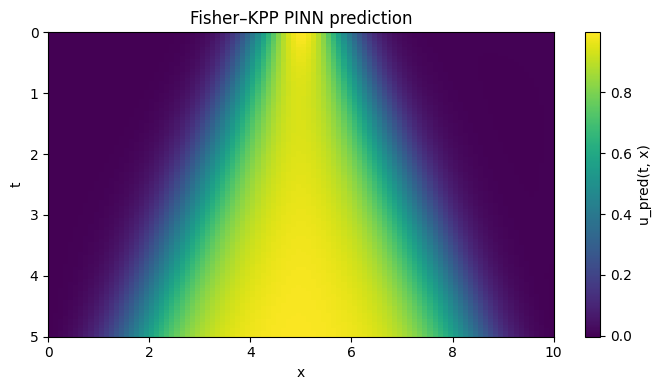

In [76]:
import matplotlib.pyplot as plt

Nt_plot, Nx_plot = 100, 100
t_plot = np.linspace(0.0, 5.0, Nt_plot, dtype=np.float32)
x_plot = np.linspace(0.0, 10.0, Nx_plot, dtype=np.float32)
T_grid, X_grid = np.meshgrid(t_plot, x_plot, indexing="ij")

t_flat = torch.from_numpy(T_grid.reshape(-1, 1)).to(model.device)
x_flat = torch.from_numpy(X_grid.reshape(-1, 1)).to(model.device)

with torch.no_grad():
    preds = model(x_flat, t_flat)["u"].cpu().numpy().reshape(Nt_plot, Nx_plot)

plt.figure(figsize=(7, 4))
plt.imshow(
    preds,
    extent=[0.0, 10.0, 5.0, 0.0],
    aspect="auto",
    origin="upper",
)
plt.colorbar(label="u_pred(t, x)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Fisher–KPP PINN prediction")
plt.tight_layout()
plt.show()

